In [47]:
from datetime import datetime, timedelta
import sys

sys.path.append("..")


from utils import get_exif_lazy
import pandas as pd
from pathlib import Path

FLIGHT_DIR = Path("/workspaces/cv/data/surveys/action-aviation/20250331_west_coast_4camera_test/flight_1/")

camera_times = []
for camera_dir in (FLIGHT_DIR / "cameras").iterdir():
    camera_name = camera_dir.name
    print(camera_name)
    for subdir in (camera_dir / "DCIM").iterdir():
        for image in sorted(subdir.iterdir()):
            exif = get_exif_lazy(image)
            t = datetime.strptime(exif["datetime"] + "." + exif["subsec_time"], "%Y:%m:%d %H:%M:%S.%f")
            camera_times.append(dict(camera=camera_name, t=t, fname=image.name, fpath=image))
camera_times = pd.DataFrame(camera_times)
camera_times


R28
L28
R09
L09


,camera,t,fname,fpath
0,R28,2025-03-31 11:44:07.112,_28R0166.JPG,/workspaces/cv/data/surveys/action-aviation/20...
1,R28,2025-03-31 11:44:09.312,_28R0167.JPG,/workspaces/cv/data/surveys/action-aviation/20...
2,R28,2025-03-31 11:44:11.314,_28R0168.JPG,/workspaces/cv/data/surveys/action-aviation/20...
3,R28,2025-03-31 11:44:13.313,_28R0169.JPG,/workspaces/cv/data/surveys/action-aviation/20...
4,R28,2025-03-31 11:44:15.314,_28R0170.JPG,/workspaces/cv/data/surveys/action-aviation/20...
...,...,...,...,...
11839,L09,2025-03-31 13:37:04.092,_09L3129.JPG,/workspaces/cv/data/surveys/action-aviation/20...
11840,L09,2025-03-31 13:37:06.094,_09L3130.JPG,/workspaces/cv/data/surveys/action-aviation/20...
11841,L09,2025-03-31 13:37:08.312,_09L3131.JPG,/workspaces/cv/data/surveys/action-aviation/20...
11842,L09,2025-03-31 13:37:10.314,_09L3132.JPG,/workspaces/cv/data/surveys/action-aviation/20...


In [48]:
# First, calculate the offsets

T0 = camera_times.t.min()
offsets = {}
min_times = camera_times.groupby("camera").t.min().reset_index(name="t")
for row in min_times.itertuples():
    offset = (T0 - row.t).total_seconds()
    assert offset < 60
    offsets[row.camera] = offset
print(offsets)
min_times["adjusted"] = min_times.apply(lambda row: row.t + timedelta(seconds=offsets[row.camera]), axis=1)
min_times


{'L09': -9.161, 'L28': -32.34, 'R09': -79.24, 'R28': 0.0}


,camera,t,adjusted
0,L09,2025-03-31 11:44:16.273,2025-03-31 11:44:07.112
1,L28,2025-03-31 11:44:39.452,2025-03-31 11:44:07.112
2,R09,2025-03-31 11:45:26.352,2025-03-31 11:44:07.112
3,R28,2025-03-31 11:44:07.112,2025-03-31 11:44:07.112


In [49]:
# OK apply that
camera_times["adjusted"] = camera_times.apply(lambda row: row.t + timedelta(seconds=offsets[row.camera]), axis=1)


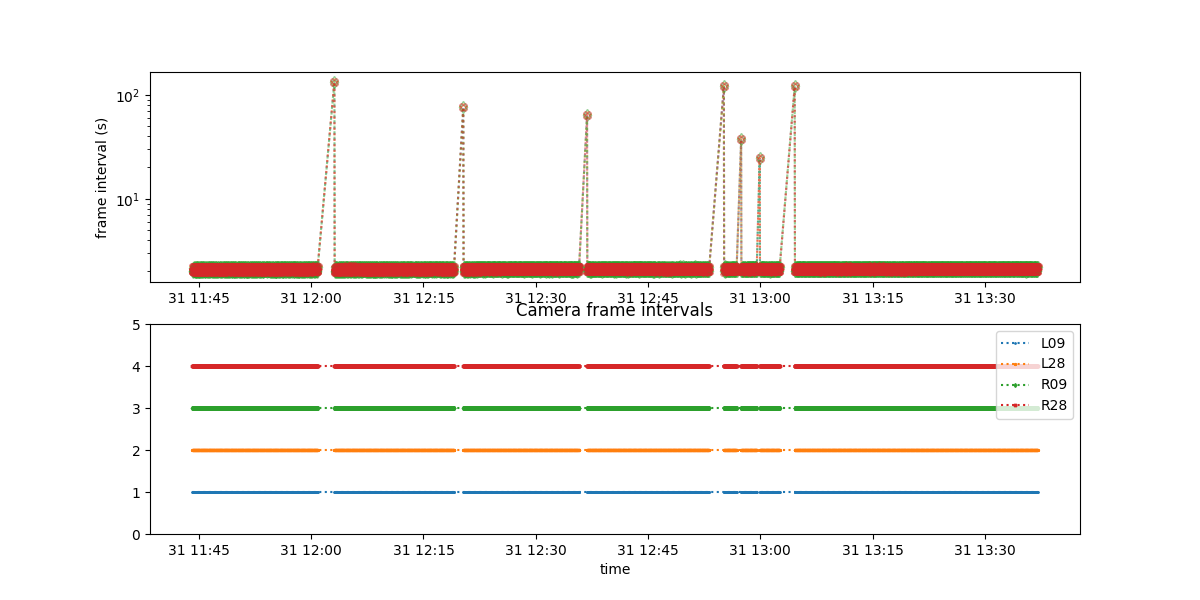

In [50]:
%matplotlib widget

# Insert some skips
import matplotlib.pyplot as plt


def plotit(df, matches=None):
    plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212, sharex=ax1)
    for idx, (camera, g) in enumerate(df.groupby("camera")):
        g = g.sort_values("adjusted")
        # g["t"] = pd.to_datetime(g.t).astype(np.int64) // 10**9
        g["dt"] = g.adjusted.diff().dt.total_seconds()
        # g['dt'] = g['dt'].clip(0,10)
        ax1.plot(
            g.adjusted,
            g.dt,
            label=camera,
            marker=".*dXP"[idx % 5],
            linestyle="dotted",
            # markersize=5,
            fillstyle="none",
            alpha=0.5,
        )
        ax2.plot(
            g.adjusted,
            [idx + 1] * len(g),
            label=camera,
            markersize=2,
            marker=".*dXP"[idx % 5],
            linestyle="dotted",
        )
    if matches is not None:
        x = [m[0].adjusted for m in matches]
        y = [len(m) for m in matches]
        ax2.fill_between(x, [0] * len(matches), y, alpha=0.25, label="matches")

    ax1.set_ylabel("frame interval (s)")
    ax2.set_xlabel("time")
    ax1.set_yscale("log")
    ax2.set_ylim(0, idx + 2)
    plt.title("Camera frame intervals")
    plt.legend()
    plt.show()


plotit(camera_times)


In [46]:
# Show 100 rows pandas:
pd.set_option("display.max_rows", 100)

# OK, first, go find all those that are after the max time, and move them out:
MIN_TIME = datetime.strptime("2025-03-31 11:30:00", "%Y-%m-%d %H:%M:%S")
camera_times[camera_times.adjusted < MIN_TIME]


,camera,t,fname,fpath,adjusted
0,R28,2025-03-31 11:27:50.112,_28R0164.JPG,/workspaces/cv/data/surveys/action-aviation/20...,2025-03-31 11:27:50.112
1,R28,2025-03-31 11:27:52.312,_28R0165.JPG,/workspaces/cv/data/surveys/action-aviation/20...,2025-03-31 11:27:52.312
2963,L28,2025-03-31 11:28:22.452,_28L0195.JPG,/workspaces/cv/data/surveys/action-aviation/20...,2025-03-31 11:27:50.112
2964,L28,2025-03-31 11:28:24.652,_28L0196.JPG,/workspaces/cv/data/surveys/action-aviation/20...,2025-03-31 11:27:52.312
7747,R09,2025-03-31 11:29:09.332,_09R8858.JPG,/workspaces/cv/data/surveys/action-aviation/20...,2025-03-31 11:27:50.112
7748,R09,2025-03-31 11:29:11.532,_09R8859.JPG,/workspaces/cv/data/surveys/action-aviation/20...,2025-03-31 11:27:52.312
8889,L09,2025-03-31 11:27:59.272,_09L0171.JPG,/workspaces/cv/data/surveys/action-aviation/20...,2025-03-31 11:27:50.112
8890,L09,2025-03-31 11:28:01.472,_09L0172.JPG,/workspaces/cv/data/surveys/action-aviation/20...,2025-03-31 11:27:52.312


In [ ]:
# Show 100 rows pandas:
pd.set_option("display.max_rows", 100)

# OK, first, go find all those that are after the max time, and move them out:
MAX_TIME = datetime.strptime("2025-04-05 15:42:26", "%Y-%m-%d %H:%M:%S")
too_late = camera_times[camera_times.adjusted > MAX_TIME]
too_late.sort_values(["camera", "adjusted"])


,camera,t,fname,fpath,adjusted


In [ ]:
# OK, go remove them manually if you're happy, and likewise the frame centers - just look for big changes in lat/lon
# Then re-run everything above

In [51]:
# OK, we want to associate an IDX to each so we can match it to the GPS. This is a bit messy as the interval can change. So let's go from the start and find the unique intervals.
cts = list(camera_times.itertuples())
cts = sorted(cts, key=lambda row: row.adjusted)
matches = []
while cts:
    interval_t = cts[0].adjusted
    # Get all the cameras that are within 0.5 second of this time:
    t0 = interval_t - timedelta(seconds=0.5)
    t1 = interval_t + timedelta(seconds=0.5)
    match = []
    while True:
        if not cts:
            break
        row = cts[0]
        if t0 < row.adjusted < t1:
            match.append(row)
            cts = cts[1:]
        else:
            break
    assert len(match) >= 3, "Only allowed one camera max failing"
    assert len(match) == len(set(row.camera for row in match)), "Only allowed one camera per match"
    matches.append(match)
    # Remove these from the list
    cts = [x for x in cts if x not in match]
    if len(matches) % 100 == 0:
        print(len(matches), end="\r")


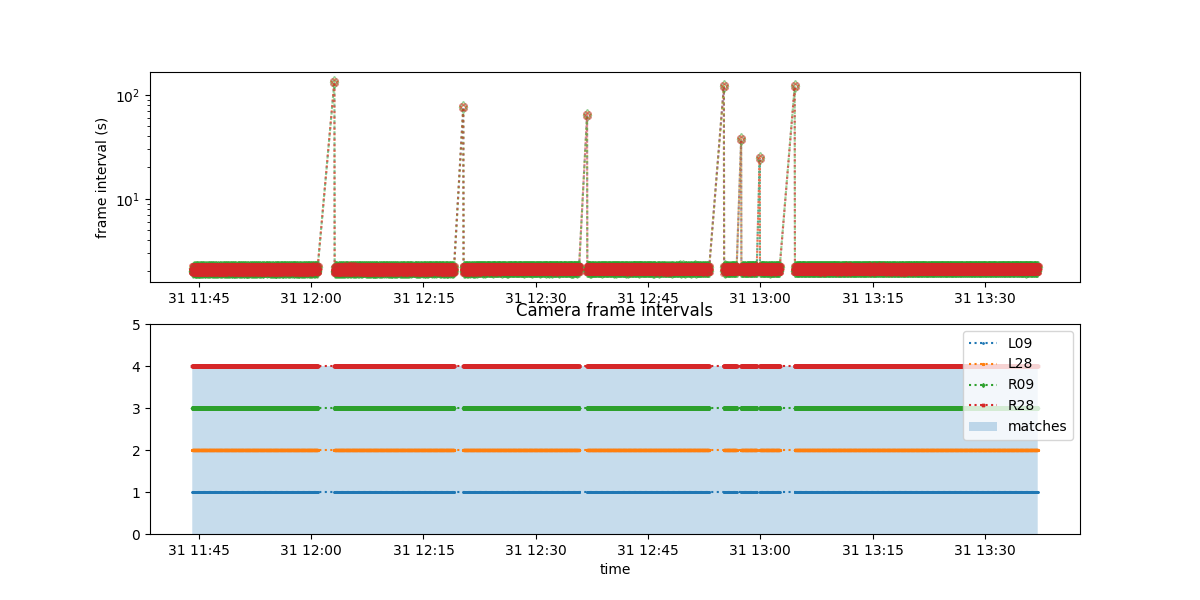

In [52]:
# Cool, how does it look?
plotit(camera_times, matches)


In [53]:
# OK, cool, easy, matched them up:
frame_centers = pd.read_csv(FLIGHT_DIR / "frame_centers.csv", header=None, names=["lat", "lon", "alt"])
frame_centers

,lat,lon,alt
0,-37.812375,174.834256,731.8947
1,-37.811490,174.834121,731.6378
2,-37.810679,174.833999,732.1822
3,-37.809870,174.833873,731.4503
4,-37.809056,174.833739,731.1152
...,...,...,...
2956,-37.822049,174.811631,753.1705
2957,-37.822194,174.810435,751.1123
2958,-37.822319,174.809117,750.6974
2959,-37.822402,174.807910,751.6432


In [54]:
print(len(matches), len(frame_centers))

2961 2961


In [55]:
import json
import pytz

# OK, now export it all
frames = []
camera_names = camera_times.camera.unique().tolist()
NZDT = pytz.timezone("Pacific/Auckland")
assert len(matches) == len(frame_centers)
for match, center in zip(matches, list(frame_centers.itertuples(index=False))):
    matchd = {
        row.camera: dict(path=str(row.fpath.relative_to(FLIGHT_DIR)), t=NZDT.localize(row.adjusted).isoformat())
        for row in match
    }
    frames.append(
        {"lat": center.lat, "lon": center.lon, "alt": center.alt, "images": {k: matchd.get(k) for k in camera_names}}
    )
out = dict(
    cameras=camera_names,
    frames=frames,
)
with open(FLIGHT_DIR / "processed_frames.json", "w") as f:
    json.dump(out, f, indent=2)

In [56]:
frames[0]

{'lat': -37.812375348,
 'lon': 174.834256071,
 'alt': 731.8947,
 'images': {'R28': {'path': 'cameras/R28/DCIM/10050331/_28R0166.JPG',
   't': '2025-03-31T11:44:07.112000+13:00'},
  'L28': {'path': 'cameras/L28/DCIM/10050331/_28L0197.JPG',
   't': '2025-03-31T11:44:07.112000+13:00'},
  'R09': {'path': 'cameras/R09/DCIM/10050331/_09R8860.JPG',
   't': '2025-03-31T11:44:07.112000+13:00'},
  'L09': {'path': 'cameras/L09/DCIM/10050331/_09L0173.JPG',
   't': '2025-03-31T11:44:07.112000+13:00'}}}